Input Variables: EMA(9), ATR(14), VWAP -> Output Variable: high

c:\Users\Asus\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Asus\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


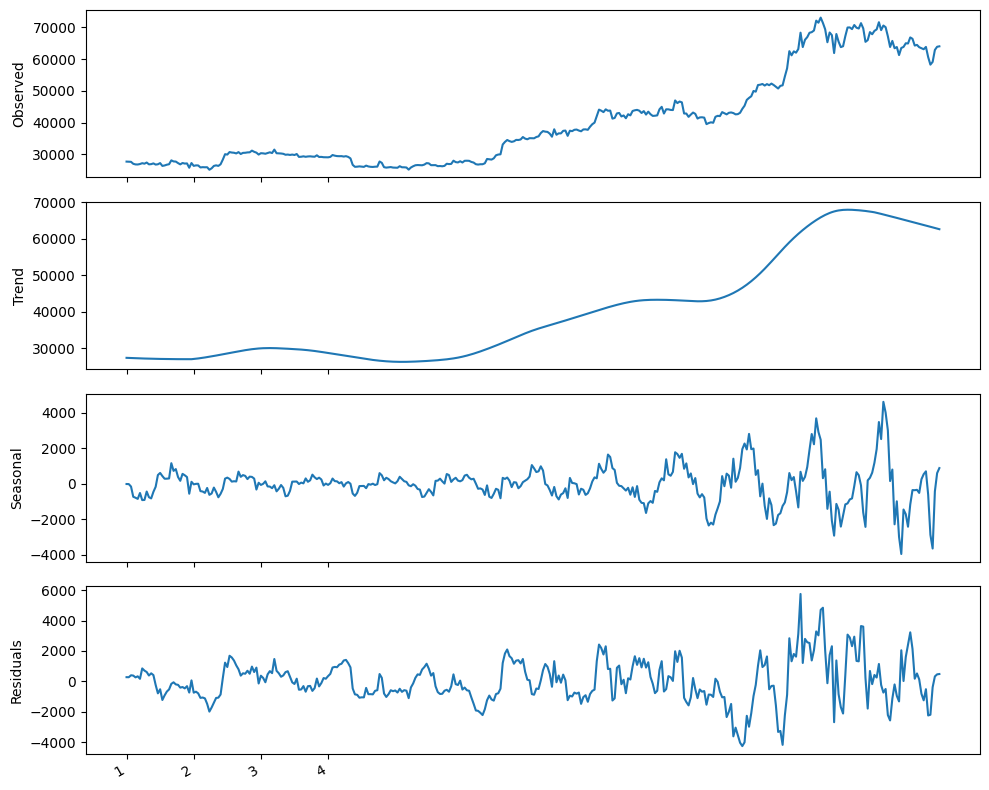

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from itertools import product
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL

bitcoin = pd.read_csv('Bitcoin2.csv', sep=';')
bitcoin = bitcoin.iloc[::-1].reset_index(drop=True)

decomposition = STL(bitcoin['close'], period=30).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
plt.xticks(np.arange(0, 120, 30), np.arange(1, 5, 1))
fig.autofmt_xdate()
plt.tight_layout()

s = 30

In [2]:
import pandas_ta as ta

bitcoin.set_index(pd.DatetimeIndex(bitcoin["timestamp"]), inplace=True)
vwap = ta.vwap(high=bitcoin['high'], low=bitcoin['low'], close=bitcoin['close'], volume=bitcoin['volume'])

# atr = ta.atr(low=bitcoin['low'], high=bitcoin['high'], close=bitcoin['close'], length=14)
ema = ta.ema(close=bitcoin['close'], length=9)

C:\Users\Asus\AppData\Local\Temp\ipykernel_15868\3220948.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  vwap = ta.vwap(high=bitcoin['high'], low=bitcoin['low'], close=bitcoin['close'], volume=bitcoin['volume'])


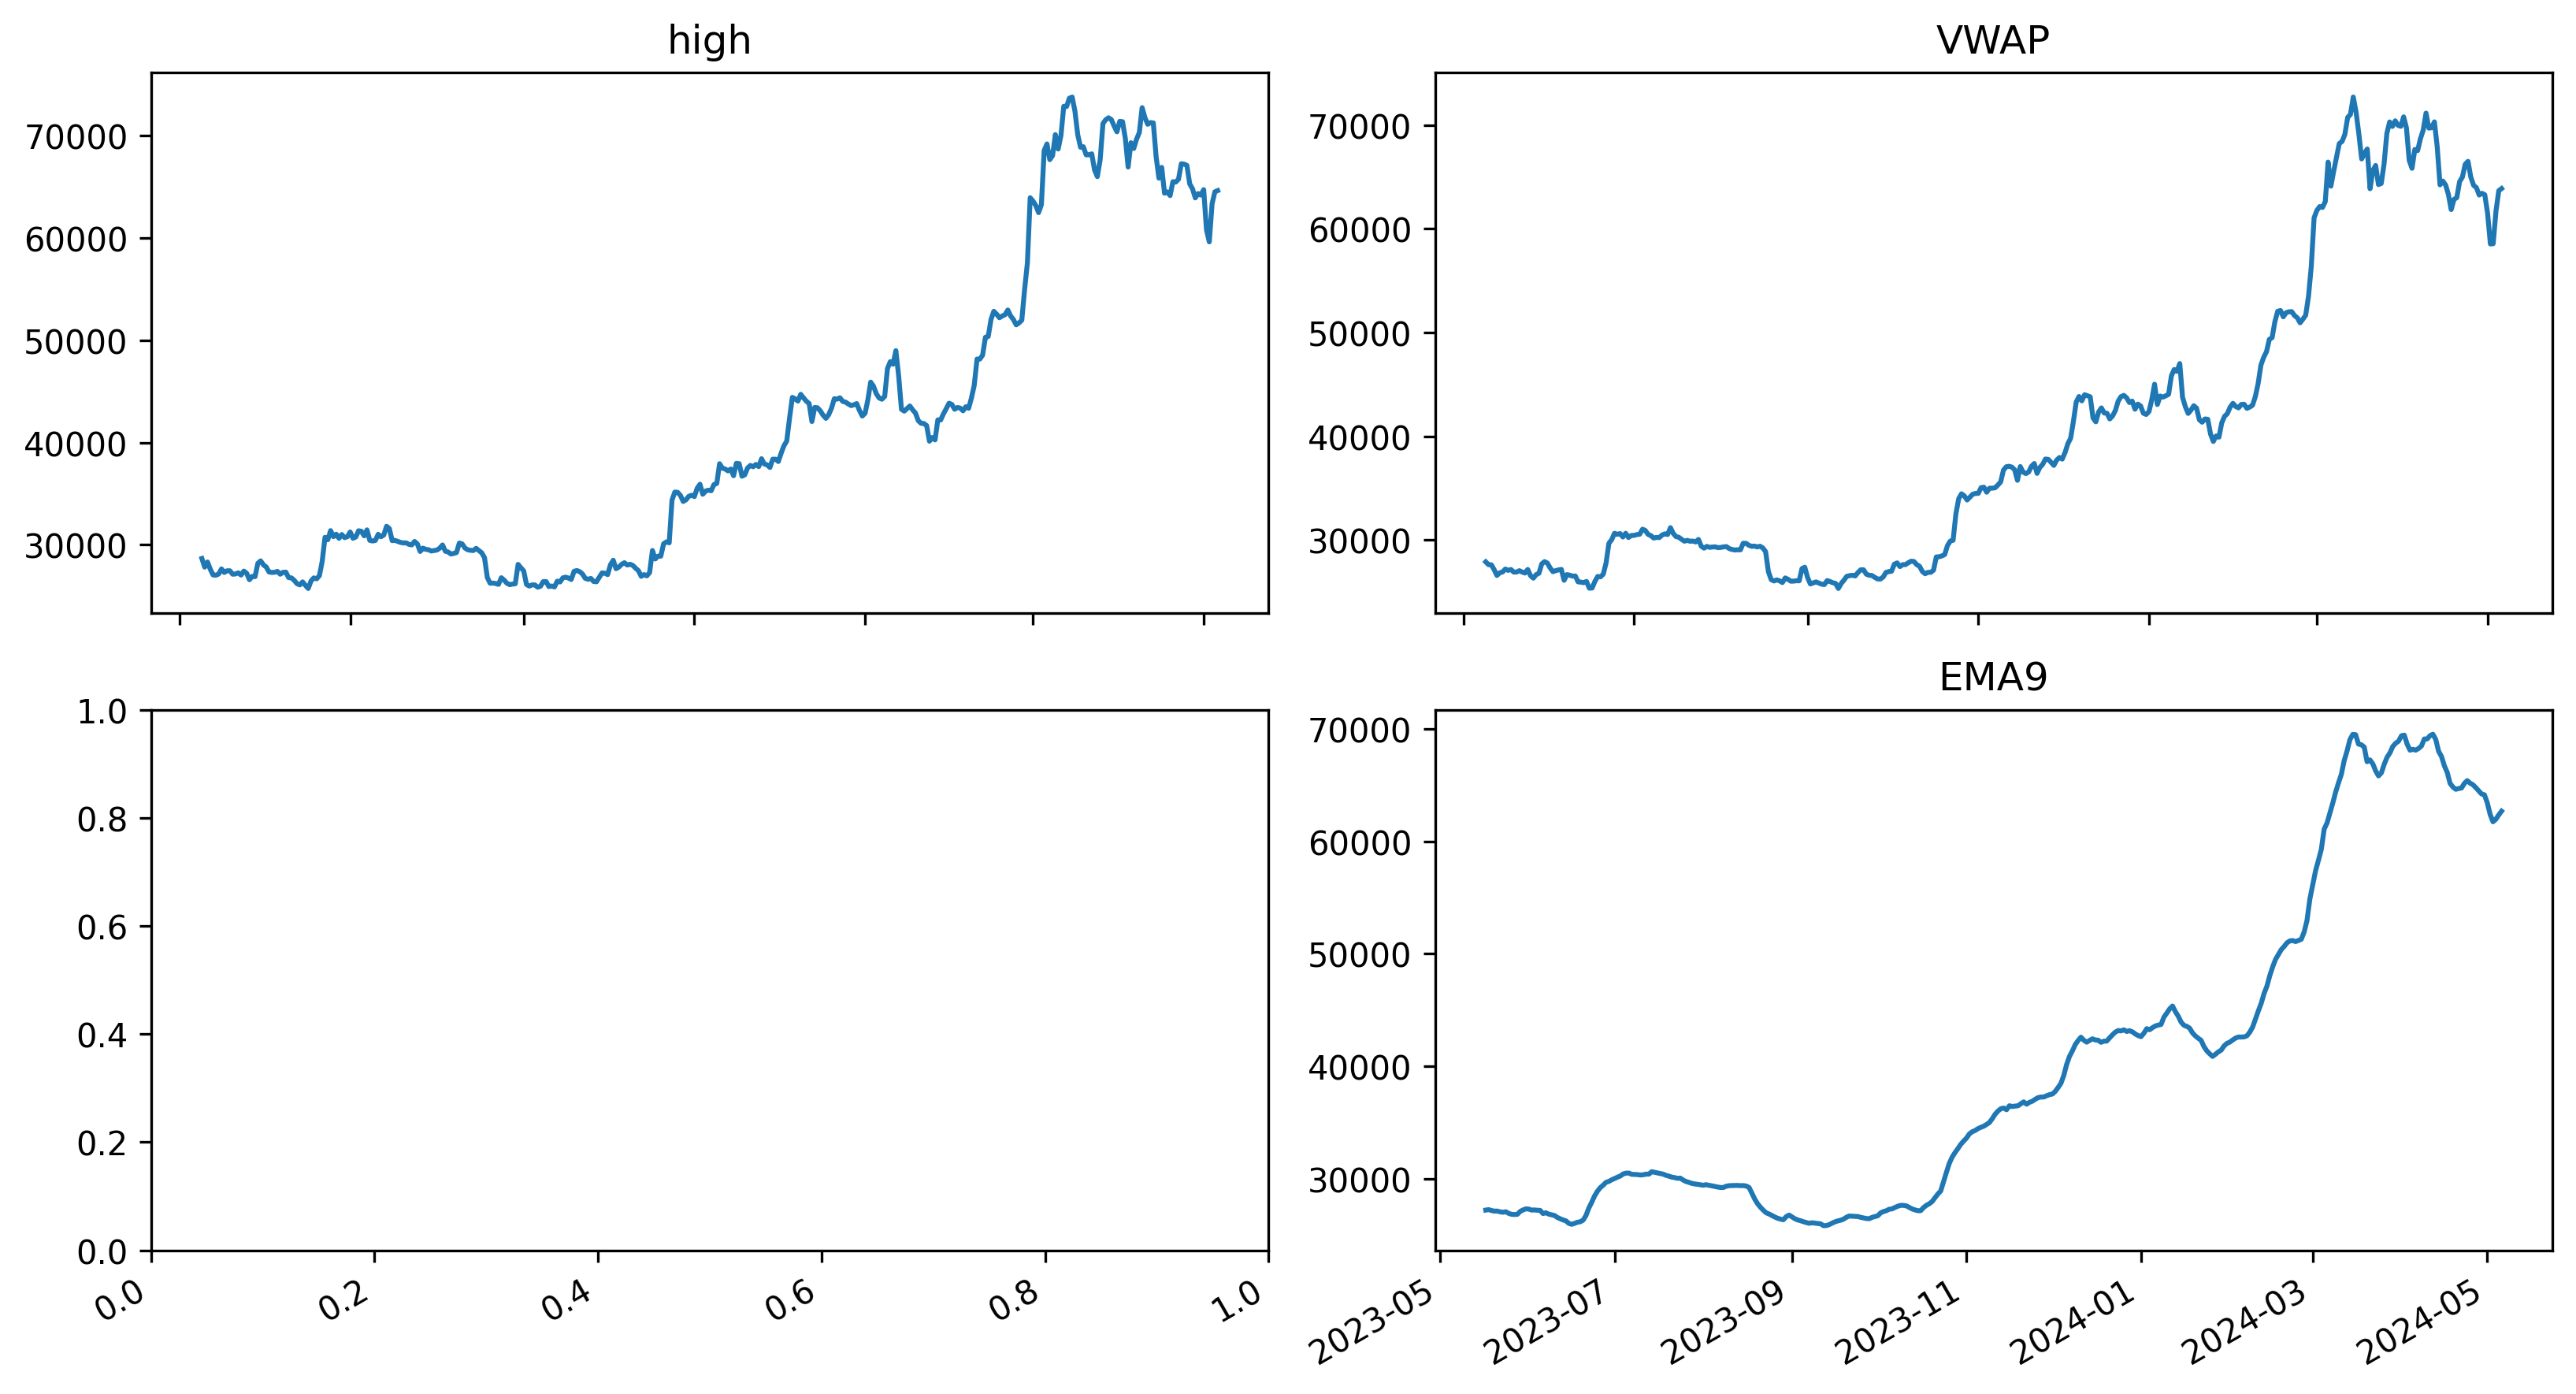

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=300, figsize=(11,6))

axes.flatten()[0].plot(bitcoin['high'])
axes.flatten()[0].set_title('high')
axes.flatten()[1].plot(vwap)
axes.flatten()[1].set_title('VWAP')
# axes.flatten()[2].plot(atr)
# axes.flatten()[2].set_title('ATR14')
axes.flatten()[3].plot(ema)
axes.flatten()[3].set_title('EMA9')
fig.autofmt_xdate()
plt.tight_layout()

In [35]:
target = bitcoin['high']
exog = pd.DataFrame({'VWAP': vwap, 'EMA': ema})

In [5]:
ad_fuller_result = adfuller(target)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.501701050403143
p-value: 0.8916841202851602


In [6]:
target_diff = target.diff() 
ad_fuller_result = adfuller(target_diff[1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.9779936522822186
p-value: 0.0015302294085482266


d = 1, D = 0

In [7]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, exog, order=(order[0], d, order[1]), seasonal_order=(order[2], D, order[3], s), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [8]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 30

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

Because of EMA(9), the first 7 values of exog['EMA'] are NULL.

In [36]:
target_train = target[8:-30]
target_test = target[-30:]
exog_train = exog[8:-30]

In [12]:
result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

C:\Users\Asus\AppData\Local\Temp\ipykernel_15868\1180966477.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

c:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init

,"(p,q,P,Q)",AIC
0,"(0, 2, 0, 1)",4939.026498
1,"(2, 1, 0, 0)",4941.335425
2,"(1, 1, 1, 0)",4941.339753
3,"(0, 2, 0, 0)",4942.146995
4,"(0, 2, 1, 0)",4942.198433
...,...,...
251,"(0, 0, 1, 3)",5077.343265
252,"(0, 0, 2, 2)",5079.017188
253,"(0, 0, 3, 2)",5079.496332
254,"(0, 0, 3, 3)",5187.155077


SARIMAX(0,1,2)(0,0,0)30

In [37]:
best_model = SARIMAX(target_train, exog_train, order=(0,1,2), seasonal_order=(0,0,1,30), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)
print(best_model_fit.summary())

c:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                 high   No. Observations:                  326
Model:             SARIMAX(0, 1, 2)x(0, 0, [1], 30)   Log Likelihood               -2463.513
Date:                              Tue, 21 May 2024   AIC                           4939.026
Time:                                      21:10:37   BIC                           4961.729
Sample:                                  05-16-2023   HQIC                          4948.087
                                       - 04-05-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
VWAP           0.9604      0.013     72.064      0.000       0.934       0.987
EMA            0.07

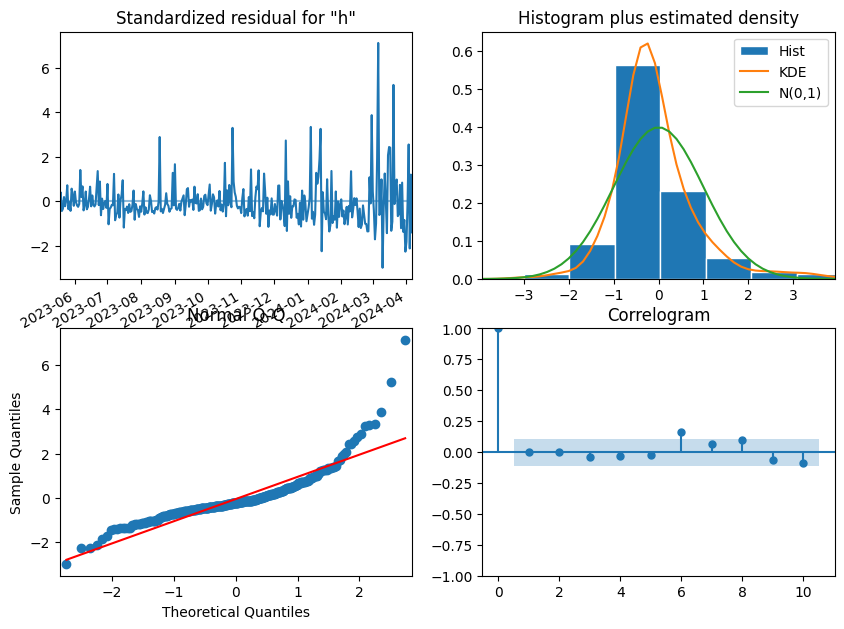

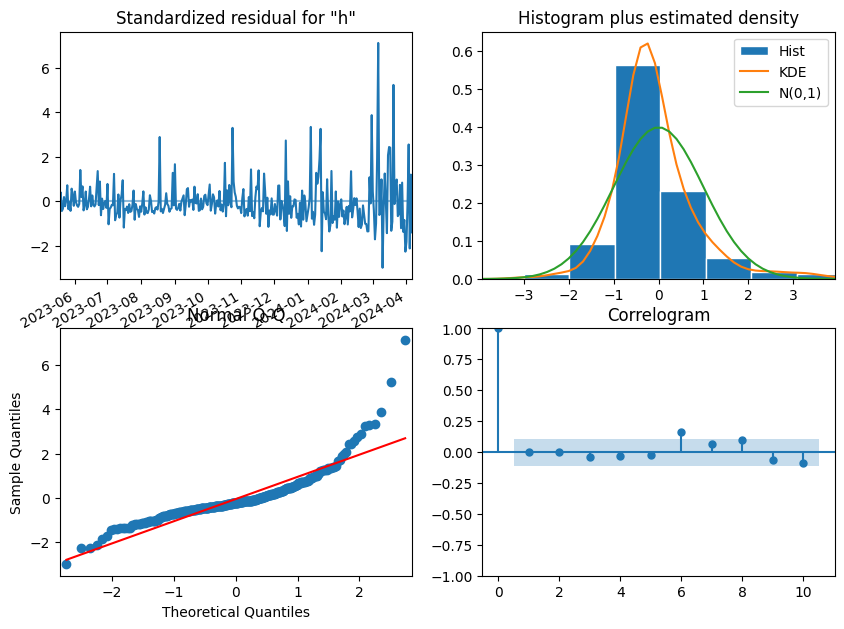

In [14]:
best_model_fit.plot_diagnostics(figsize=(10,8))

In [15]:
residuals = best_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.000090,0.992439
2,0.006442,0.996784
3,0.438966,0.932080
4,0.696113,0.951807
5,0.932705,0.967809
6,10.046623,0.122702
7,11.363847,0.123517
8,14.134615,0.078323
9,15.548218,0.076937
10,18.112081,0.053102


In [38]:
def rolling_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
 
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
 
        return pred_last_value
    elif method == 'SARIMAX':
        pred_SARIMAX = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(0,1,2), seasonal_order=(0,0,1,30), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
        return pred_SARIMAX

In [39]:
pred_df = pd.DataFrame({'actual': target_test})
TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

In [40]:
target = target[8:]
exog = exog[8:]

In [41]:
pred_last_value = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX
pred_df

c:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will b

,actual,pred_last_value,pred_SARIMAX
timestamp,,,
2024-04-06 23:59:59.999000+00:00,69629.602049,68725.758357,69386.230190
2024-04-07 23:59:59.999000+00:00,70284.426265,69629.602049,70235.627448
2024-04-08 23:59:59.999000+00:00,72715.359609,70284.426265,70969.629598
2024-04-09 23:59:59.999000+00:00,71742.506324,72715.359609,72728.077115
2024-04-10 23:59:59.999000+00:00,71093.433161,71742.506324,71477.203438
2024-04-11 23:59:59.999000+00:00,71256.238130,71093.433161,71484.999715
2024-04-12 23:59:59.999000+00:00,71222.742979,71256.238130,71871.918584
2024-04-13 23:59:59.999000+00:00,67931.429364,71222.742979,69611.716951
2024-04-14 23:59:59.999000+00:00,65824.427083,67931.429364,66725.087115


In [42]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

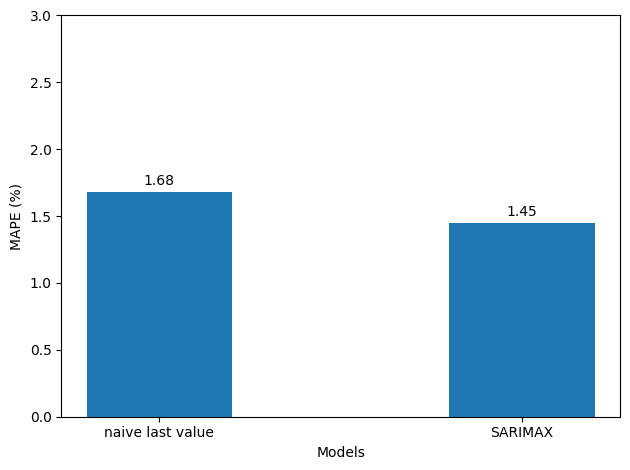

In [43]:
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)
fig, ax = plt.subplots()
x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 3)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
plt.tight_layout()

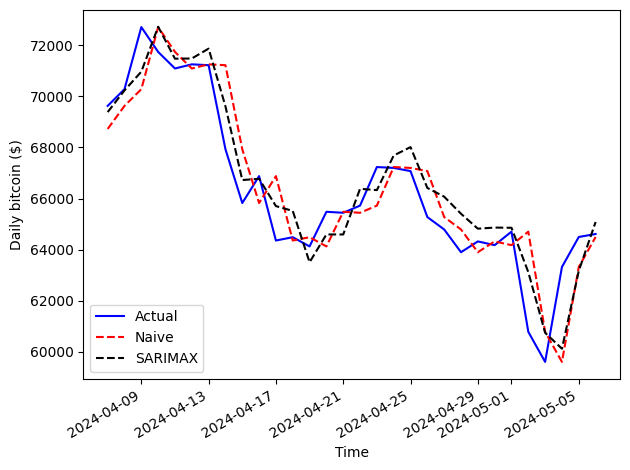

In [44]:
fig, ax = plt.subplots()

ax.plot(pred_df['actual'], 'b-', label='Actual')
ax.plot(pred_df['pred_last_value'], 'r--', label='Naive')
ax.plot(pred_df['pred_SARIMAX'], 'k--', label='SARIMAX')
ax.legend(loc=3)
ax.set_xlabel('Time')
ax.set_ylabel('Daily bitcoin ($)')
fig.autofmt_xdate()
plt.tight_layout()